$$ ITI \space AI-Pro: \space Intake \space 44 $$
$$ Deep \space Learning $$
$$ Lab \space no. \space 4 $$

# `01` Assignment 01
- Design your own U-Net to segment the lung fields from chest computed tomography CT images (download from [here](https://drive.google.com/file/d/1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9/view?usp=sharing)) into one of the 2 classes lung or chest (background)
- Image Size: $512\times512\times1$
- Use a generator to load the images
(**Hint:** You can use `tensorflow.keras.preprocessing.image.ImageDataGenerator` or `tensorflow.keras.utils.image_dataset_from_directory`)
- Use 85% of the provided data for training and 15% for validation.
- Use $32 → 64 → 128 → 256 → 512 → 256 → 128 → 64 → 32$ architecture.
- Use $3\times3$ **Convolution**, $2\times2$ **MaxPooling**, and **Dropout** of $20-30\%$.
- Use `binary_crossentropy` for the loss calculation, `Adam` for optimization and `accuracy` for metrics.

## `+` Import Libraries

In [1]:
import gdown

In [2]:
import tensorflow as tf
from tensorflow import keras

from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [3]:
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten
from keras.layers import Input, RandomFlip, Rescaling, RandomRotation, Lambda
from keras.layers import Conv2DTranspose, Concatenate
from tensorflow.keras.optimizers import Adam

# `+` Seed Value

In [4]:
SEED = 907
BATCH_SIZE = 8

## `+` Downlaod, Load & Preprocess Chest CT Data

### Download & Extract the Dataset

In [7]:
gdown.download(id= '1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9')

Downloading...
From (original): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9
From (redirected): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9&confirm=t&uuid=d0a38a95-6dea-4265-a760-2601d7d14d72
To: /content/Lung_Data.zip
100%|██████████| 41.1M/41.1M [00:01<00:00, 28.5MB/s]


'Lung_Data.zip'

In [8]:
%%capture
!unzip Lung_Data.zip

### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [9]:
# Training Generator/Dataset
train_img_gen = ImageDataGenerator(
                   horizontal_flip=True,
                   rescale=1/255.,
                   validation_split=0.15
                   )

In [10]:
train_image_ds = train_img_gen.flow_from_directory(
    directory='Lung_Data',
    target_size=(512, 512),
    color_mode='grayscale',
    class_mode=None,
    subset='training',
    classes=['grey'],
    seed=SEED,
    batch_size= BATCH_SIZE
)

train_mask_ds = train_img_gen.flow_from_directory(
    directory='Lung_Data',
    target_size=(512, 512),
    color_mode='grayscale',
    class_mode=None,
    subset='training',
    classes=['mask'],
    seed=SEED,
    batch_size=BATCH_SIZE
)

Found 184 images belonging to 1 classes.
Found 184 images belonging to 1 classes.


In [ ]:
# Validation Generator/Dataset

val_img_gen = ImageDataGenerator(
                   rescale=1/255.,
                   validation_split=0.15
                   )

In [ ]:
val_image_ds = val_img_gen.flow_from_directory(
    directory='Lung_Data',
    target_size=(512, 512),
    color_mode='grayscale',
    class_mode=None,
    subset='validation',
    classes=['grey'],
    seed=SEED,
    batch_size=BATCH_SIZE
)

val_mask_ds = val_img_gen.flow_from_directory(
    directory='Lung_Data',
    target_size=(512, 512),
    color_mode='grayscale',
    class_mode=None,
    subset='validation',
    classes=['mask'],
    seed=SEED,
    batch_size=BATCH_SIZE
)

Found 32 images belonging to 1 classes.
Found 32 images belonging to 1 classes.


### Preview the Images

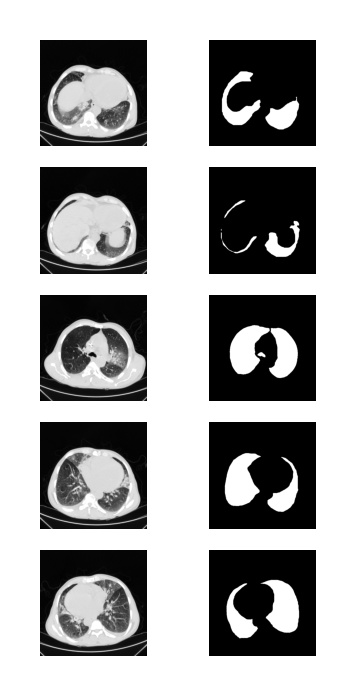

In [ ]:
# Preview Images
plt.figure(figsize=(1, 2), dpi=400)
images, masks = train_image_ds.next(), train_mask_ds.next()
for i in range(5):
  plt.subplot(5, 2, i*2+1)
  plt.imshow(images[i], cmap='gray')
  plt.axis('off')
  plt.subplot(5, 2, i*2+2)
  plt.imshow(masks[i], cmap='gray')
  plt.axis('off')

## `+` Set Global Parameters

In [26]:
# Hyperparameters
BATCH_SIZE  = 32
EPOCHS      = 50

## `i` Model Design

In [ ]:
def double_conv(x, n_filters):
  x = Conv2D(n_filters, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
  x = Dropout(0.3)(x)
  x = Conv2D(n_filters, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
  x = Dropout(0.3)(x)

  return x

In [ ]:
def downsample_block(x, n_filters):
  f = double_conv(x, n_filters)
  p = MaxPool2D(pool_size=(2, 2))(f)
  p = Dropout(0.3)(p)

  return f, p

In [ ]:
def upsample_block(x, skip_features, n_filters):
  x = Conv2DTranspose(n_filters, (3, 3), 2, padding='same')(x)
  x = Concatenate()([x, skip_features])
  x = Dropout(0.3)(x)
  x = double_conv(x, n_filters)

  return x

In [ ]:
inputs = Input((512, 512, 1))

# Encoder
f1, p1 = downsample_block(inputs, 32)
f2, p2 = downsample_block(p1, 64)
f3, p3 = downsample_block(p2, 128)
f4, p4 = downsample_block(p3, 256)

# Bottleneck
bottleneck = double_conv(p4, 512)

# Decoder
u5 = upsample_block(bottleneck, f4, 256)
u6 = upsample_block(u5, f3, 128)
u7 = upsample_block(u6, f2, 64)
u8 = upsample_block(u7, f1, 64)

# 1x1 Conv
outputs = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(u8)

model = keras.Model(inputs, outputs, name='simple_unet')
model.summary()

Model: "simple_unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d_95 (Conv2D)          (None, 512, 512, 32)         320       ['input_6[0][0]']             
                                                                                                  
 dropout_103 (Dropout)       (None, 512, 512, 32)         0         ['conv2d_95[0][0]']           
                                                                                                  
 conv2d_96 (Conv2D)          (None, 512, 512, 32)         9248      ['dropout_103[0][0]']         
                                                                                        

## `ii` Model Compilation & Training

In [ ]:
Optimizer = Adam(learning_rate=0.01)

model.compile(optimizer= Optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
train_segment_gen = zip(train_image_ds, train_mask_ds)
val_segment_gen = zip(val_image_ds, val_mask_ds)

In [ ]:
train_history = model.fit(train_segment_gen,
          epochs= EPOCHS,
          steps_per_epoch=train_image_ds.samples//BATCH_SIZE,
          validation_data=val_segment_gen,
          validation_steps=val_image_ds.samples//BATCH_SIZE
          )

Epoch 1/50
5/5 [==============================] - 13s 1s/step - loss: 202919.0312 - accuracy: 0.6358 - val_loss: 1.8841 - val_accuracy: 0.0192
Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 1.5526 - accuracy: 0.3432 - val_loss: 0.6372 - val_accuracy: 0.6095
Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 0.6639 - accuracy: 0.6569 - val_loss: 0.5830 - val_accuracy: 0.9272
Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 0.5817 - accuracy: 0.8090 - val_loss: 0.4405 - val_accuracy: 0.9818
Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 0.5044 - accuracy: 0.8653 - val_loss: 0.3925 - val_accuracy: 0.9698
Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 0.4437 - accuracy: 0.8911 - val_loss: 0.3518 - val_accuracy: 0.9629
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 0.4172 - accuracy: 0.8881 - val_loss: 0.3165 - val_accuracy: 0.9612
Epoch 8/50
5/5 [===================

Epoch 1/50
23/23 [==============================] - 29s 1s/step - loss: 0.5495 - accuracy: 0.8799 - val_loss: 0.3917 - val_accuracy: 0.8872
Epoch 2/50
23/23 [==============================] - 23s 1s/step - loss: 0.4101 - accuracy: 0.8768 - val_loss: 0.3938 - val_accuracy: 0.8793
Epoch 3/50
23/23 [==============================] - 21s 938ms/step - loss: 0.3792 - accuracy: 0.8730 - val_loss: 0.4036 - val_accuracy: 0.8615
Epoch 4/50
23/23 [==============================] - 22s 963ms/step - loss: 0.2747 - accuracy: 0.8853 - val_loss: 0.2507 - val_accuracy: 0.8691
Epoch 5/50
23/23 [==============================] - 22s 966ms/step - loss: 0.2322 - accuracy: 0.8751 - val_loss: 0.2134 - val_accuracy: 0.8800
Epoch 6/50
23/23 [==============================] - 21s 928ms/step - loss: 0.1962 - accuracy: 0.8797 - val_loss: 0.1979 - val_accuracy: 0.9154
Epoch 7/50
23/23 [==============================] - 22s 946ms/step - loss: 0.1569 - accuracy: 0.9318 - val_loss: 0.2248 - val_accuracy: 0.9318
Epoch

## `iii` Model Evaluation

In [ ]:
# Evaluate the model on the validation set
evaluation = model.evaluate(val_segment_gen, steps = val_image_ds.samples//BATCH_SIZE)

1/1 [==============================] - 0s 334ms/step - loss: 0.1720 - accuracy: 0.9767


## `iv` Result Visualization

In [ ]:
ACCURACY1 = train_history.history['accuracy']

In [ ]:
ACCURACY1_val = train_history.history['val_accuracy']

In [ ]:
loss1 = train_history.history['loss']

In [ ]:
loss1_val = train_history.history['val_loss']

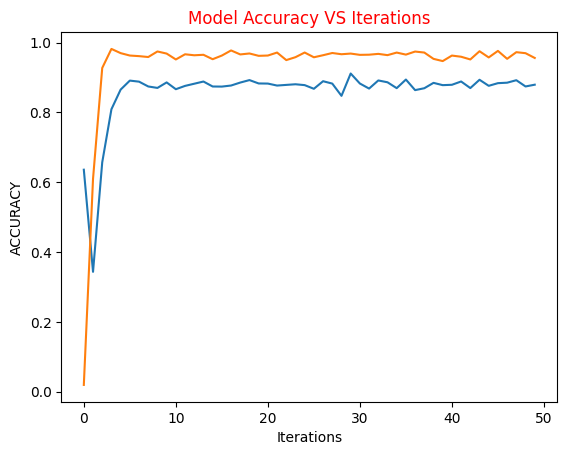

In [ ]:
plt.plot(ACCURACY1)[1:]
plt.plot(ACCURACY1_val)[1:]
plt.xlabel('Iterations')
plt.ylabel('ACCURACY')
plt.title('Model Accuracy VS Iterations', color='red')
plt.show();



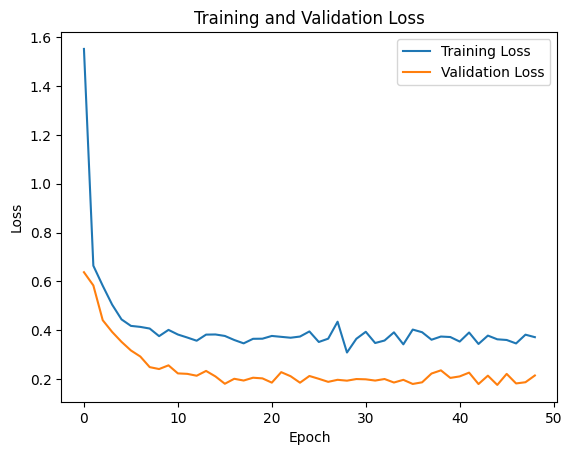

In [ ]:
plt.plot(train_history.history['loss'][1:], label='Training Loss')
plt.plot(train_history.history['val_loss'][1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

---
Validation Loss is Lower than Training loss which is A weired Observation, However Here is an explanation for what may have happened: ✍
---
Dropout penalizes model variance by randomly freezing neurons in a layer during model training. Like L1 and L2 regularization, dropout is only applicable during the training process and affects training loss, leading to cases where validation loss is lower than training loss.

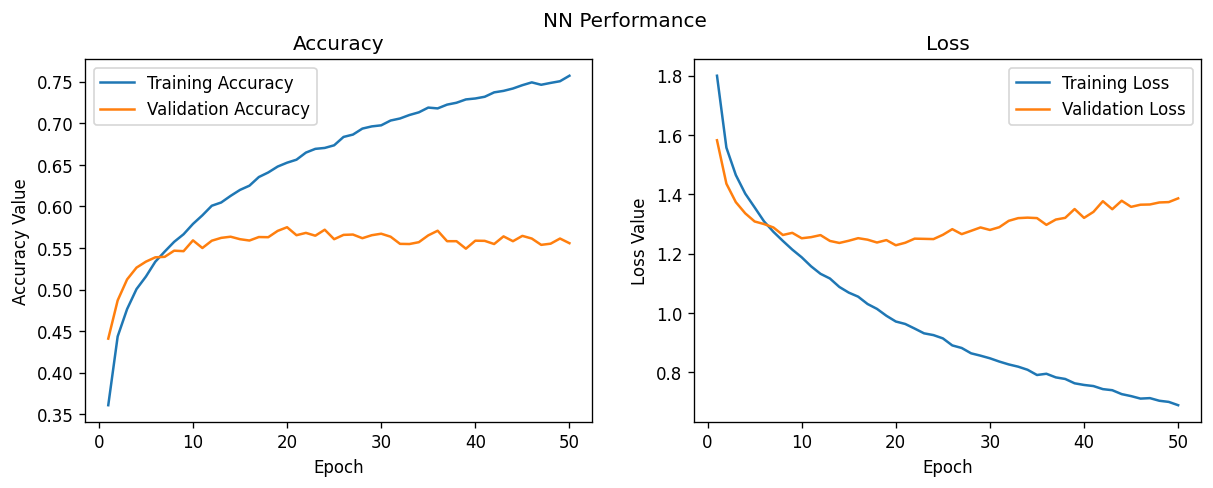

In [ ]:
# Plot the training and validation accuracy and loss


## `v` It's Time for Segmentation!!

Let's try to predict the mask of some validation samples and plot the results.

In [ ]:
import matplotlib.pyplot as plt


# Predict masks for validation samples
num_samples_to_predict = 5  # Number of samples to predict
predicted_masks = []
for i, (image, mask) in enumerate(val_segment_gen):
    if i == num_samples_to_predict:
        break
    predicted_mask = model.predict(image)  # Assuming 'model' is your trained model
    predicted_masks.append(predicted_mask)

# Plot the results for predicted masks
for i, (image, predicted_mask) in enumerate(zip(val_image_ds.take(num_samples_to_predict), predicted_masks)):
    # Plot original image
    plt.subplot(num_samples_to_predict, 2, i*2 + 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Plot predicted mask
    plt.subplot(num_samples_to_predict, 2, i*2 + 2)
    plt.imshow(predicted_mask)
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 28ms/step
1.04918666e-23 0.98422664


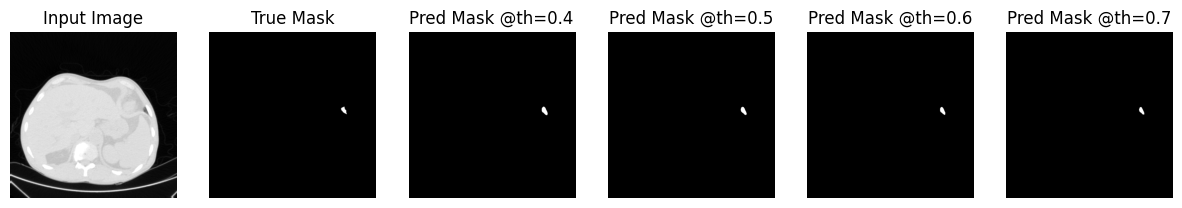

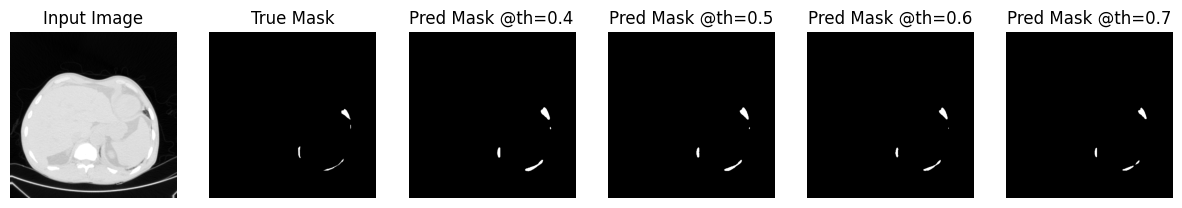

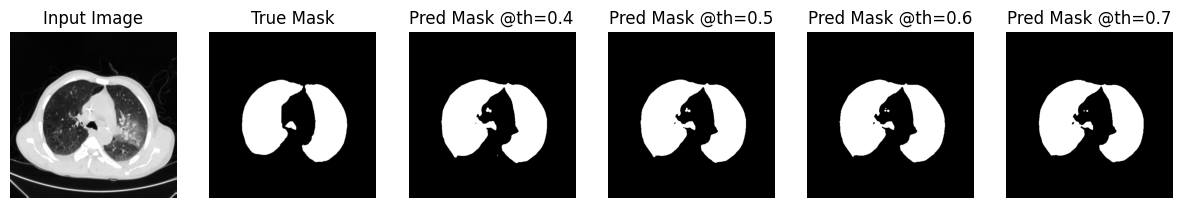

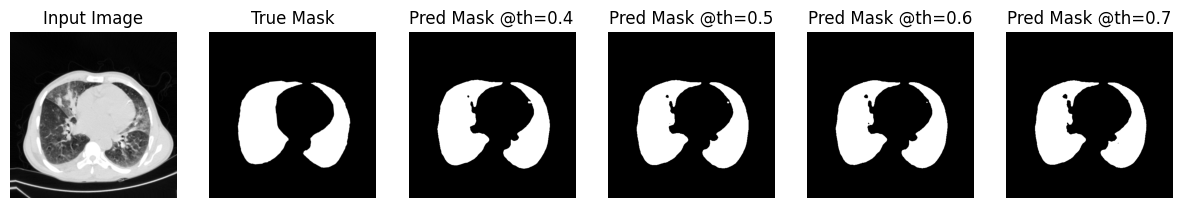

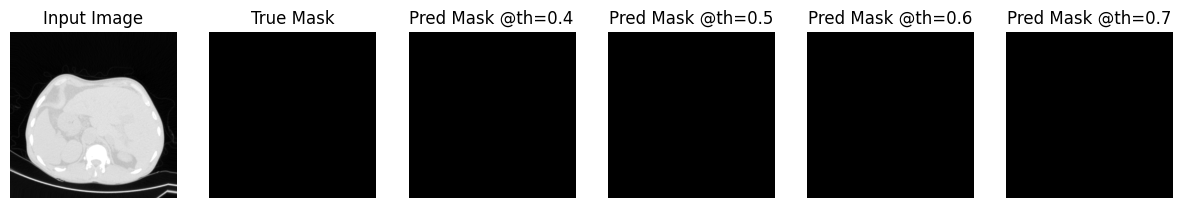

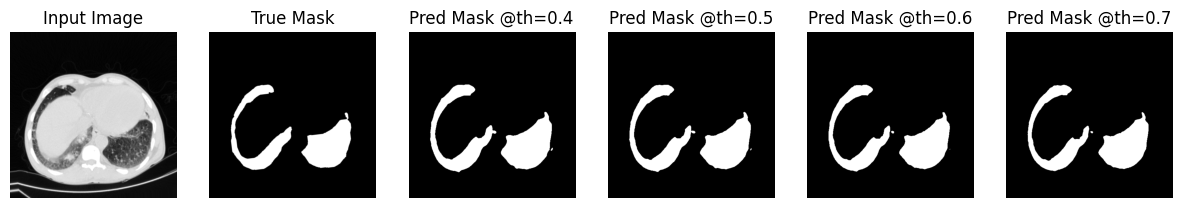

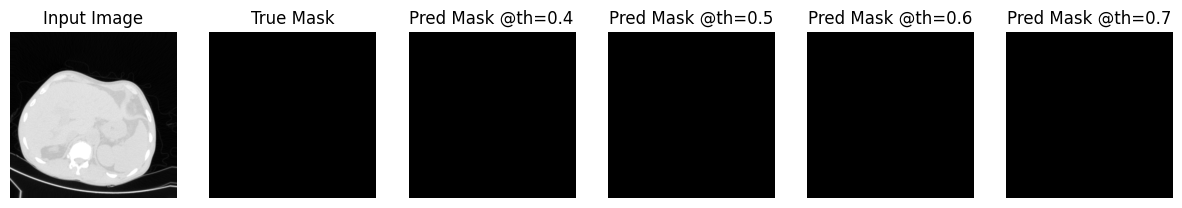

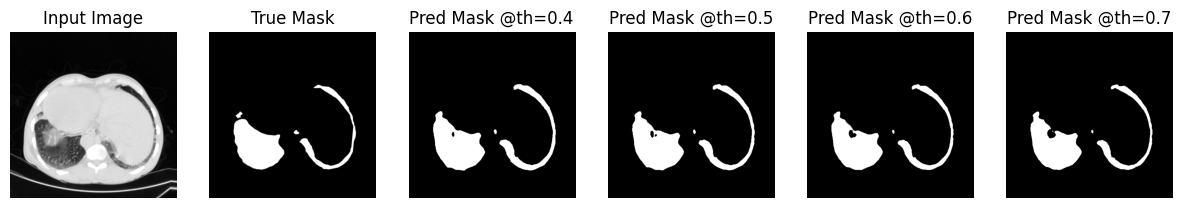

In [ ]:
# Plot the Input, True Mask, and Predicted Mask


**Note:** You can add more trials and explore different hyperparameters and design decisions as you want.

------------------------------

# Assignment 02
- Design your Deep Convolutional Neural Network using `Transfer Learning`
- You can select any pretrained model as a base and build on top.
- The task is to successfully classify images of cats and dogs using the dataset [here](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip).
- There are no constraint; you have **full power**.

## `+` Downlaod, Load & Preprocess Cats & Dogs Data

### Download & Extract the Dataset

In [5]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  89.2M      0  0:00:08  0:00:08 --:--:-- 92.5M


In [6]:
!unzip -q kagglecatsanddogs_5340.zip
!ls -Rd PetImages/*

PetImages/Cat  PetImages/Dog


In [7]:
# Delete Corrupted Images
import os
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [8]:
# Training Generator/Dataset
train_img_gen = ImageDataGenerator(
                   horizontal_flip=True,
                   rescale=1/255.,
                   validation_split=0.15
                   )

In [9]:
train_image_ds2 = train_img_gen.flow_from_directory(
    directory='PetImages',
    target_size=(512, 512),
    color_mode='rgb',
    class_mode= 'categorical',
    subset='training',
    classes=['Cat', 'Dog'],
    seed=SEED,
    batch_size= BATCH_SIZE
)


Found 19899 images belonging to 2 classes.


In [10]:
# Validation Generator/Dataset

val_img_gen = ImageDataGenerator(
                   rescale=1/255.,
                   validation_split=0.15
                   )

In [11]:
val_image_ds2 = val_img_gen.flow_from_directory(
    directory='PetImages',
    target_size=(512, 512),
    color_mode='rgb',
    class_mode= 'categorical',
    subset='validation',
    classes=['Cat','Dog'],
    seed=SEED,
    batch_size=BATCH_SIZE
)


Found 3511 images belonging to 2 classes.


### Preview the Images

In [12]:
# Function to plot images
def plot_images(images, labels):
    n = len(images)
    f, axes = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        axes[i].imshow(images[i])
        axes[i].set_title(f'Label: {labels[i]}')
        axes[i].axis('off')
    plt.tight_layout()

    plt.show()

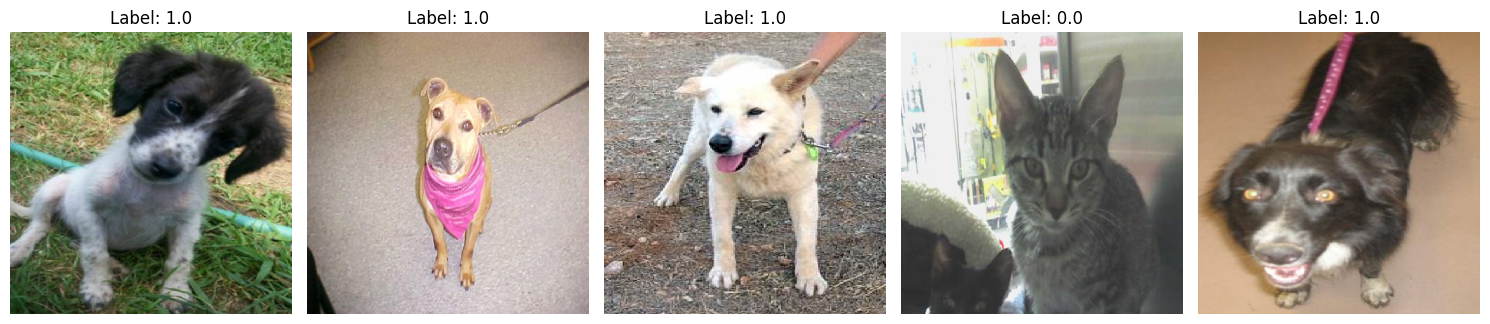

In [13]:

# Fetch a batch of images
images, labels = next(train_image_ds2)

# Plot the first few images from the batch
plot_images(images[:5], labels[:5])

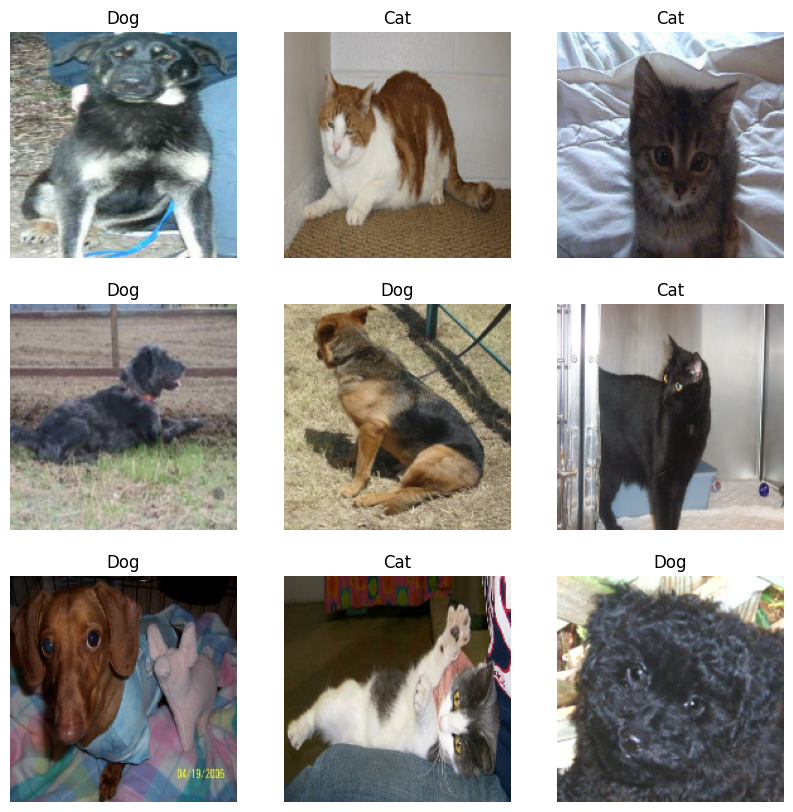

In [ ]:
# Preview Images


## `+` Set Global Parameters

In [12]:
# Hyperparameters
BATCH_SIZE  = 128
EPOCHS      = 10

## `i` Model Design

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_classifier(input_shape, num_classes):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    encoder_layers = [
        resnet50.get_layer(name).output for name in [
            'conv1_relu',
            'conv2_block3_out',
            'conv3_block4_out',
            'conv4_block6_out'
        ]
    ]

    """ Bridge """
    bridge = resnet50.layers[-1].output

    """ Decoder """
    x = bridge
    for layer in reversed(encoder_layers):
        x = decoder_block(x, layer, layer.shape[-1] // 2)

    """ Classifier """
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs, name="ResNet50_Classifier")
    return model

if __name__ == "__main__":
    input_shape = (512, 512, 3)
    num_classes = 2  # For binary classification between cats and dogs
    model = build_resnet50_classifier(input_shape, num_classes)
    model.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "ResNet50_Classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)           

## `ii` Model Compilation & Training

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
train_history2 = model.fit(train_image_ds2,
          epochs= EPOCHS,
          steps_per_epoch=train_image_ds2.samples//BATCH_SIZE,
          validation_data= val_image_ds2,
          validation_steps= val_image_ds2.samples//BATCH_SIZE
          )

Epoch 1/10
155/155 [==============================] - 194s 836ms/step - loss: 0.6607 - accuracy: 0.5960 - val_loss: 1.1958 - val_accuracy: 0.4954
Epoch 2/10
155/155 [==============================] - 129s 832ms/step - loss: 0.6456 - accuracy: 0.6129 - val_loss: 0.7217 - val_accuracy: 0.5324
Epoch 3/10
155/155 [==============================] - 125s 805ms/step - loss: 0.6519 - accuracy: 0.6048 - val_loss: 0.7368 - val_accuracy: 0.5231
Epoch 4/10
155/155 [==============================] - 125s 808ms/step - loss: 0.6209 - accuracy: 0.6387 - val_loss: 0.7074 - val_accuracy: 0.5000
Epoch 5/10
155/155 [==============================] - 128s 827ms/step - loss: 0.6256 - accuracy: 0.6363 - val_loss: 0.7533 - val_accuracy: 0.5231
Epoch 6/10
155/155 [==============================] - 125s 804ms/step - loss: 0.6116 - accuracy: 0.6540 - val_loss: 0.6663 - val_accuracy: 0.5741
Epoch 7/10
155/155 [==============================] - 128s 828ms/step - loss: 0.6105 - accuracy: 0.6702 - val_loss: 0.6508 -

## `iii` Model Evaluation

In [16]:
# Evaluate the model on the validation set
evaluation = model.evaluate(val_image_ds2, steps = val_image_ds2.samples//BATCH_SIZE)

27/27 [==============================] - 7s 246ms/step - loss: 0.5163 - accuracy: 0.7454


## `iv` Result Visualization

In [17]:
ACCURACY2 = train_history2.history['accuracy']

In [18]:
ACCURACY2_val = train_history2.history['val_accuracy']

In [19]:
loss2 = train_history2.history['loss']

In [20]:
loss2_val = train_history2.history['val_loss']

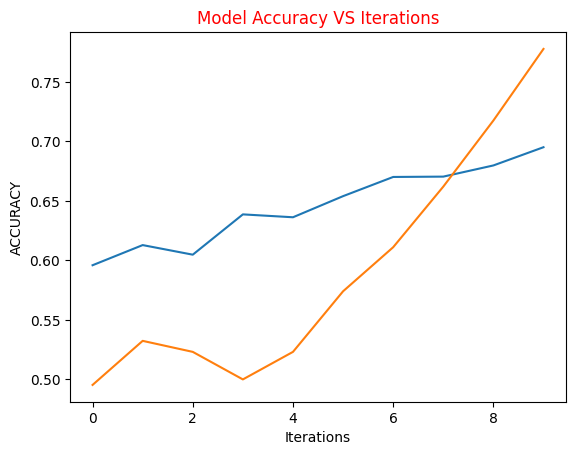

In [21]:
plt.plot(ACCURACY2, label='Training Accuracy')
plt.plot(ACCURACY2_val, label='validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('ACCURACY')
plt.title('Model Accuracy VS Iterations', color='red')
plt.show();



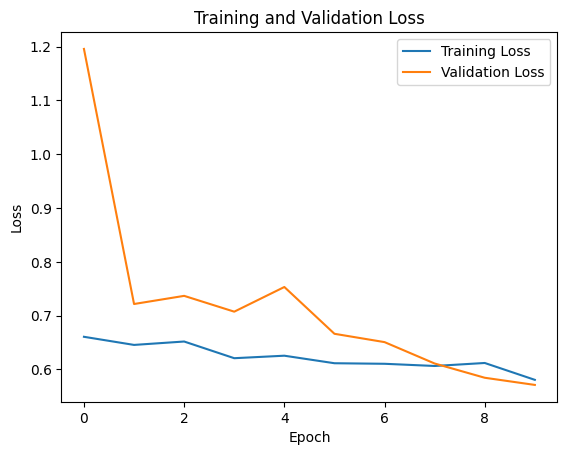

In [22]:
plt.plot(loss2, label='Training Loss')
plt.plot(loss2_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## `iv` Result Visualization

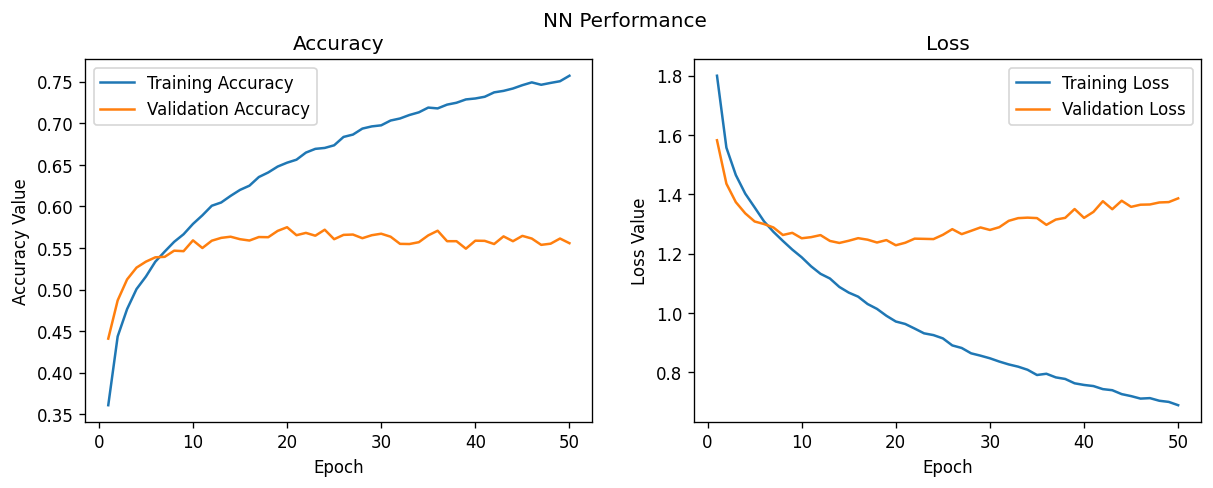

In [ ]:
# Plot the training and validation accuracy and loss


## `v` Let's Test Our Model

Let's try to predict the class of some validation samples and plot the results.

Also, try to classify an image from the internet.

**Note:** remember to properly process the image (dimensions, rescaling, etc.)

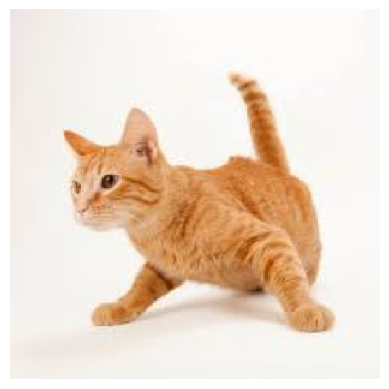

In [32]:
from tensorflow.keras.preprocessing import image

# Load the image
img_path = 'download.jpg'
img = image.load_img(img_path, target_size=(512, 512))

# Convert the image to an array
img_array = image.img_to_array(img)

# Display the image
plt.imshow(img_array.astype('uint8'))
plt.axis('off')
plt.show()


In [24]:

# Function to predict class of an image
def predict_image(model, img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(512, 512))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale pixel values

    # Predict class probabilities
    predictions = model.predict(img_array)

    # Get predicted class index
    predicted_class_index = np.argmax(predictions[0])

    return predicted_class_index, predictions[0]

In [26]:
predict_image(model,img_path= 'download.jpg')

1/1 [==============================] - 4s 4s/step


(0, array([0.73938143, 0.2606185 ], dtype=float32))

In [ ]:
# Plot the Input, True Label, and Predicted Label


----------------------------------------------

$$ Wish \space you \space all \space the \space best \space ♡ $$
$$ Abdelrahman \space Eid $$